In [15]:
%load_ext autoreload
%autoreload 2

import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
import pickle
import copy as cp
import scipy.optimize
import casadi as cas


PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)

import src.vehicle as veh
import src.traffic_world as tw
# import src.IterativeBestResponseMPCMultiple as mibr
# import src.car_plotting_multiple as cmplot
import src.multiagent_mpc as mpc
np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
ego_veh = veh.Vehicle(.1)
ado_veh = veh.Vehicle(.1)

In [25]:
def get_ellipse(L, W):
    min_elipse_a =  lambda a: (1 - L**2/(2*a)**2 - W**2/(2*a + W - L)**2)
    
    ax = scipy.optimize.fsolve(min_elipse_a, L/2.0)
    by = ax + .5*(W-L)
    return ax, by

def R(phi):
    return np.array([[np.cos(phi), np.sin(phi)],[-np.sin(phi), np.cos(phi)]])


def Q_minkowski(R_e, M_e, R_a, M_a):
    '''Aaron's Code'''
    M_e_curr = R_e @ M_e
    M_a_curr = R_a @ M_a
    Q1 = M_e_curr @ M_e_curr.T
    Q2 = M_a_curr @ M_a_curr.T
    beta = np.sqrt(np.trace(Q1) / np.trace(Q2))
    Q_minkowski = (1+1/beta) * Q1 + (1+beta) * Q2
    return Q_minkowski

def dist_squared(Xe, Xa, Q_minkowski):
    ### Ellipse is Ego centered
    return (Xa - Xe).T @ np.linalg.inv(Q_minkowski) @ (Xa - Xe)

In [26]:
R_e = np.eye(2)
M_e = np.eye(2)*2
R_a = np.eye(2)
M_a = np.eye(2)*3

In [27]:
Q = Q_minkowski(R_e, M_e, R_a, M_a)
Q

array([[25.,  0.],
       [ 0., 25.]])

In [28]:
c = np.array([[0],[0]])

In [29]:
xt = np.array([[4],[0]])
xt.T @ np.linalg.inv(Q) @ xt <= 1

array([[ True]])

In [30]:
W = 1.8
L = 4.5


phi_e = 0 * np.pi/180
phi_a = 5 * np.pi/180

a_e, b_e = get_ellipse(ego_veh.L, ego_veh.W)
a_a, b_a = get_ellipse(ado_veh.L, ado_veh.W)

# M_e =  np.array([[1/a_e**2, 0],[0, 1/b_e**2]], dtype=float)
# M_a =  np.array([[1/a_a**2, 0],[0, 1/b_a**2]], dtype=float)
M_e =  np.array([[a_e, 0],[0, b_e]], dtype=float)
M_a =  np.array([[a_a, 0],[0, b_a]], dtype=float)


R_e = R(phi_e)
R_a = R(phi_a)

x_e, y_e = 0, 1
x_a, y_a = 6.5, 0
Xe = np.array([[x_e],[y_e]])
Xa = np.array([[x_a], [y_a]])

## Calculate the Ellipse Obstacle

### Plot the Ellipses

[[1.85]] 1.846
[[0.19]] 0.185417
[[2.34]] 2.344
[[0.86]] 0.857124
[[4.01]] 4.00818
[[0.01]] 0.0137891
[[3.04]] 3.04406
[[1.14]] 1.13683
[[1.26]] 1.25892
[[0.61]] 0.610925
[[0.51]] 0.505016
[[3.63]] 3.6321
[[2.]] 1.99898
[[1.49]] 1.49227
[[0.3]] 0.299739
[[2.15]] 2.15404
[[2.44]] 2.44295
[[0.51]] 0.506502
[[0.57]] 0.569699
[[3.43]] 3.42954
[[5.05]] 5.04896
[[1.08]] 1.07959
[[0.67]] 0.667422
[[3.22]] 3.21974
[[1.93]] 1.93343
[[1.35]] 1.34791
[[0.41]] 0.406179
[[1.23]] 1.22973
[[0.63]] 0.627548
[[0.86]] 0.855966


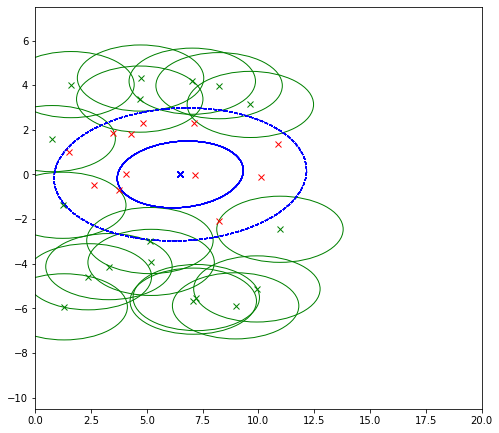

In [47]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
for i_test_point in range(30):
#     fig = plt.figure(edgecolor='red')
    x_e = x_a + np.random.uniform(-6,6)
    y_e = y_a + np.random.uniform(-6, 6)    
    phi_e = 0 * np.pi/180
    
    
    
    Xa = np.array([[x_a], [y_a]])
    
    Xe = np.array([[x_e],[y_e]])
    plt.plot(x_a, y_a, 'x', color='blue')

    ax = plt.gca()
    ax.axis('square')
    # ax.add_patch(c)
    plt.xlim([0, 20])
    plt.ylim([-10.5, 7.5])
    
    e2 = patches.Ellipse((x_a, y_a), 2*a_a, 2*b_a, angle=np.rad2deg(phi_a), fill=False, edgecolor='blue')
    ax.add_patch(e2)

    Q_m = Q_minkowski(R_e, M_e, R_a, M_a)
    d = dist_squared(Xa, Xe, Q_m)
    collision = d <= 1
    dist_squared1 = mpc.minkowski_ellipse_collision_distance(ego_veh, ado_veh, x_e, y_e, phi_e, x_a, y_a, phi_a)
    collision1 = dist_squared1 <= 1
    if collision1:
        color = 'red'
    else:
        color = 'green'
    plt.plot(x_e, y_e, 'x', color=color)
    if not collision1:
        e1 = patches.Ellipse((x_e, y_e), 2*a_e, 2*b_e, angle=np.rad2deg(phi_e), fill=False, edgecolor=color)
        ax.add_patch(e1)
    print(d, dist_squared1)


    w, v = np.linalg.eig(Q_m)
    a_q, b_q = np.sqrt(w[0]), np.sqrt(w[1])
    v = v.T
    phi_q = np.arctan2(v[1,0], v[0,0])
    qp = patches.Ellipse((x_a, y_a), 2*a_q, 2*b_q, angle=np.rad2deg(phi_q), fill=False, edgecolor='blue', linestyle='--')
    ax.add_patch(qp)
    

#     plt.setp(ax.spines.values(), color=color)    
#     fig.set_edgecolor('red')
plt.show()

In [43]:
dist_squared1 = mpc.minkowski_ellipse_collision_distance(ego_veh, ado_veh, x_e, y_e, phi_e, x_a, y_a, phi_a, numpy=False)


In [45]:
float(dist_squared1)

2.5142104068070137

In [204]:
Q = Q_minkowski(R_e, M_e, R_a, M_a)


In [206]:
e = np.linalg.eig(np.linalg.inv(Q))

In [207]:
e

(array([0.04, 0.08]), array([[-0.91, -0.42],
        [ 0.42, -0.91]]))

In [117]:
(Xa - Xe).T @ np.linalg.inv(Q_m) @ (Xa-Xe)

array([[0.75]])

[[ True]]


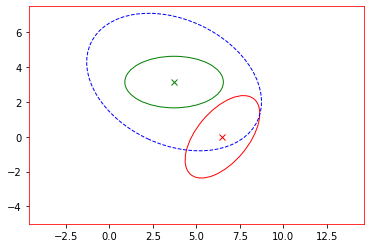

In [166]:
phi_e = 0 * np.pi/180

Xe = np.array([[x_e],[y_e]])
plt.plot(x_e, y_e, 'x', color='green')
plt.plot(x_a, y_a, 'x', color='red')

ax = plt.gca()
ax.axis('equal')
# ax.add_patch(c)
plt.xlim([-5, 15])
plt.ylim([-5, 7.5])


e1 = patches.Ellipse((x_e, y_e), 2*a_e, 2*b_e, angle=np.rad2deg(phi_e), fill=False, edgecolor='green')
ax.add_patch(e1)

e2 = patches.Ellipse((x_a, y_a), 2*a_a, 2*b_a, angle=np.rad2deg(phi_a), fill=False, edgecolor='red')
ax.add_patch(e2)

Q_m = Q_minkowski(R_e, M_e, R_a, M_a)
w, v = np.linalg.eig(Q_m)
a_q, b_q = np.sqrt(w[0]), np.sqrt(w[1])
# v = v.T
phi_q = np.arctan2(v[1,0], v[0,0])
qp = patches.Ellipse((x_e, y_e), 2*a_q, 2*b_q, angle=np.rad2deg(phi_q), fill=False, edgecolor='blue', linestyle='--')
ax.add_patch(qp)

collision = dist_squared(Xa, Xe, Q_m) <= 1
print(collision)
if collision:
    color = 'red'
else:
    color = 'green'
plt.setp(ax.spines.values(), color=color)    
#     fig.set_edgecolor('red')
plt.show()

In [149]:
t = np.linspace(0, 2*np.pi)
n = len(t)
x1 = np.cos(t).reshape(1,n)
x2 = np.sin(t).reshape(1,n)
X = np.concatenate((x1,x2), axis=0)
Y = Q_m @ (X - Xe)

(-208.71155052182945,
 -151.7843897134392,
 -17.956463477796415,
 18.615679010588213)

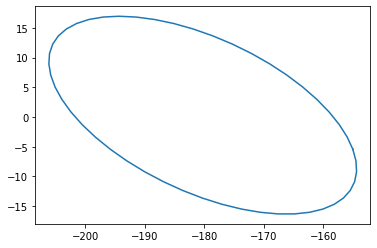

In [150]:
plt.plot(Y[0,:], Y[1,:])
ax = plt.gca()
ax.axis('equal')


In [103]:
np.rad2deg(phi_q)

25.000000000000004

In [265]:
Xe, Xa,((Xa - Xe).T @ np.linalg.inv(Q_minkowski) @ (Xa - Xe))


(array([[0],
        [1]]), array([[6.5],
        [0. ]]), array([[1.69]]))

In [255]:
((Xe - Xa)/T * np.linalg.inv(Q_minkowski) * (Xe - Xa).T) 

array([[ 1.83, -0.1 ],
       [-0.1 ,  0.07]])

[[False]]


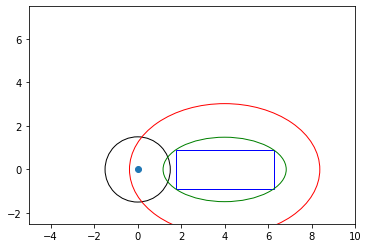

In [16]:
### Another way to see it as following
plt.plot(x_e, y_e,'o')
c = patches.Circle((x_e, y_e), radius=r, fill=None)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c)
plt.xlim([-5, 10])
plt.ylim([-2.5, 7.5])

plt.plot(x_o, y_o)
a = 2.832
b = 1.4820


# a_val = 4.5
# b_val = 1.8
W = 1.8
L = 4.5
rec = patches.Rectangle((x_o-L/2, y_o-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
a_val = 2.832
b_val = 1.4820

delta = 0.0447


# a_val, b_val = 3.897114298575689, 1.1022703788869466
e = patches.Ellipse((x_o, y_o), 2*(a_val), 2*(b_val), fill=False, edgecolor='green')
e_b = patches.Ellipse((x_o, y_o), 2*(a_val+delta+r), 2*(b_val+delta+r), fill=False, edgecolor='red')
ax.add_patch(e)
ax.add_patch(e_b)

collision_free = (np.array([[dx],[dy]]).T @ R_o.T @ np.array([[1/alpha**2, 0],[0, 1/beta**2]]) @ R_o @ np.array([[dx],[dy]])) > 1
print(collision_free)

In [ ]:
import casadi as cas

In [ ]:
opti = cas.Opti()
a = opti.variable()
b = opti.variable()
opti.minimize(a*b**2)
opti.subject_to( ((L/2)**2/a**2 + (W/2)**2/b**2) <= 1)
opti.subject_to(a>0)
opti.subject_to(b>0)
opti.solver('ipopt')

In [ ]:
opti.set_initial(a, 1)
opti.set_initial(b, 1.5)
solution = opti.solve()

In [ ]:
a_val = solution.value(a)
b_val = solution.value(b)
print(a_val, b_val)

In [ ]:
(L/2)**2/a_val**2 + (W/2)**2/b_val**2

In [ ]:
plt.plot([a_val*np.cos(t) for t in np.linspace(0, 2*np.pi, 50)], [b_val*np.sin(t) for t in np.linspace(0, 2*np.pi, 50)])

## From MATLAB

In [ ]:
clear all 
close all
clc 

%% 
W = 1.8;
L = 4.5;

min_elipse_box = @(a) (1 - L^2/(2*a)^2 - W^2/(2*a + W - L)^2) ;
a = fzero(min_elipse_box, 10)
b = a + 1/2*(W-L)
t = 0:.1:2*pi;
x = a*cos(t);
y = b*sin(t);
plot(x,y)
rectangle('Position',[-L/2 -W/2 L W])
axis('equal')
hold on
 
%% ellipsoid and circle dimensions
%a = 10; 
%b = 2; 
r = 1.5;
 
M = 400; 
dtheta = 2*pi / M; 
theta_M = (0 : dtheta : 2*pi)'; 


minimal_positive_root = @(delta) (2*(delta + r)^2*(2*a*b + a*(delta + r) + b*(delta + r)))/((a + b)*(a + b + 2*delta + 2*r))-r^2; 
x0 = 1.5; % initial guess must be always positive
delta = fzero(minimal_positive_root,x0)
disp(delta)
a_new = a+delta+r
b_new = b+delta+r

x = a_new*cos(t);
y = b_new*sin(t);
plot(x,y)

%%

for i = 1 : M+1 
    theta = theta_M(i); 
    
    %% ellipse coordinates
    x_M(i) = a * cos(theta); 
    y_M(i) = b * sin(theta); 
     
    alpha = a+delta+r; 
    beta = b+delta+r; 

    %% bounding ellipse
    
    x_1_M(i) = alpha * cos(theta); 
    y_1_M(i) = beta * sin(theta); 
    
    %% Minkowsky sum of ellipse (a,b) and circle r
    x_2_M(i) = a*cos(theta) + r*cos(theta)/(sqrt((cos(theta))^2 + (a^2/b^2)*(sin(theta))^2)); 
    y_2_M(i) = b*sin(theta) + r*sin(theta)/(sqrt((b^2/a^2)*(cos(theta))^2 + (sin(theta))^2));    
     

    %% previously used bounding ellipse
    a_3 = a + r; 
    b_3 = b + r; 
    x_3_M(i) = a_3 * cos(theta); 
    y_3_M(i) = b_3 * sin(theta); 
     
    %% circle coordinates
    x_4_M(i) = r * cos(theta); 
    y_4_M(i) = r * sin(theta); 
end 

h=figure; 
hold all; 
box on; 
grid on; 
axis equal; 
plot(x_M, y_M, '-r') 

plot(x_1_M, y_1_M, '-k') 
plot(x_2_M, y_2_M, '-b') 
plot(x_3_M, y_3_M, '-r')
legend("Ellipse","Minimal Bounding ellipse","Minkowski Sum","Bound Ellipse + Circle","Circle")
% legend(h,'off')
plot(x_4_M, y_4_M, '-g') 
% circle(0,0,a+r)


K = randi([floor(M/4/4), ceil(M/4/2)]); 
theta = theta_M(K); 
x = a * cos(theta); 
y = b * sin(theta); 
plot([0,x], [0, y], '-k') 
normal = r*[2*cos(theta)/a; 2*sin(theta)/b] / norm([2*cos(theta)/a; 2*sin(theta)/b]); 
plot([0, normal(1)], [0, normal(2)], '-b') 
plot([x, normal(1)+x], [y, normal(2)+y], '-b')
circle(normal(1)+x, normal(2)+y, r)
hold all
 
% theta_T = theta_M(1 : ceil(M/2)+1); 
% theta_T = theta_M; 
% delta_x_T = cos(theta_T) .* (r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)) - 1); 
% delta_y_T = sin(theta_T) .* (r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)) - 1); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_x_T, '-k'); 
% plot(delta_y_T, '-r'); 
%  
% delta_a_T = r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)); 
% delta_b_T = r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_a_T, '-k'); 
% plot(delta_b_T, '-r'); 

%%Curvature calculation
% k=a*b/(sqrt(a^2/2+b^2/2)^3)
% k_r=(a+r)*(b+r)/(sqrt((a+r)^2/2+(b+r)^2/2)^3)
% t=0:0.01:2*pi
% figure;
% plot(t,a.*b./(sqrt(a.^2.*cos(t).^2+b.^2.*sin(t).^2).^3))
% hold on;
% ar=a+r;
% br=b+r;
% plot(t,ar.*br./(sqrt(ar.^2.*cos(t).^2+br.^2.*sin(t).^2).^3),'b')
% figure;
% plot(t,a^2.*cos(t).^2+b^2.*sin(t).^2)

function h = circle(x,y,r)
    hold on
    th = 0:pi/50:2*pi;
    xunit = r * cos(th) + x;
    yunit = r * sin(th) + y;
    h = plot(xunit, yunit);
%     hold off
end



